# Part 2: Simple Text Processing - Tokenization, Lemmatization, Word Frequency, Vectorization 

### Read Data

In [31]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-dark') 

In [32]:
# read in SOTU.csv using pandas, name the variable `sou` for simplicity
# the below cell is what the output should look like
# read in SOTU.csv 
sou = pd.read_csv('data/SOTU.csv')
sou.head()

,President,Year,Text,Word Count
0,Joseph R. Biden,2024.0,"\n[Before speaking, the President presented hi...",8003
1,Joseph R. Biden,2023.0,\nThe President. Mr. Speaker——\n[At this point...,8978
2,Joseph R. Biden,2022.0,"\nThe President. Thank you all very, very much...",7539
3,Joseph R. Biden,2021.0,\nThe President. Thank you. Thank you. Thank y...,7734
4,Donald J. Trump,2020.0,\nThe President. Thank you very much. Thank yo...,6169


## Part 2: Simple Text Processing - Tokenization, Lemmatization, Word Frequency, Vectorization (20 pts)

Now we will start working on simple text processing using the `SpaCy` package and the same dataset as Part 1. The package should already be included in the `environment.yml`. However, we will also need to download `en_core_web_sm`, an English language text processing model. To do this, while having your `sotu` environment activated, run the following:

```
python -m spacy download en_core_web_sm
```

Now, you should be good to go!

Some important definitions:

- *Token*: a single word or piece of a word
- *Lemma*: the core component of a word, e.g., "complete" is the lemma for "completed" and "completely"
- *Stop Word*: a common word that does not add semantic value, such as "a", "and", "the", etc.
- *Vectorization*: representing a document as a vector where each index in the vector corresponds to a token or word and each entry is the count.

In this section, we will explore the most common tokens and lemmas throughout different slices of the speech data. We will also develop vectorization representations of the speeches. 

 The core steps are:

1. Process speeches using the SpaCy nlp module
2. Analyze Tokens vs Lemmas:
- Create a list of all tokens across all speeches that are not stop words, punctuation, or spaces.
- Create a second list of the lemmas for these same tokens.
- Display the top 25 for each of these and compare.
3. Analyze common word distributions over different years:
- Create a function that takes the dataset and a year as an input and outputs the top n lemmas for that year's speeches
- Compare the top 10 words for 2023 versus 2019
4. Document Vectorization:
- Train a Term Frequency-Inverse Document Frequency (TF-IDF) vectorization model using your processed dataset and scikit learn
- Output the feature vectors 

**Helpful Resources:**
- https://realpython.com/natural-language-processing-spacy-python/
- https://www.statology.org/text-preprocessing-feature-engineering-spacy/ 
- https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html# 
- https://www.geeksforgeeks.org/nlp/how-to-store-a-tfidfvectorizer-for-future-use-in-scikit-learn/ 



### Processing Speeches with SpaCy

Lets study just speeches from 2000 and onwards to begin with. So, be sure to subset your DataFrame to just these speeches before continuing!

In [33]:
!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 62.8 MB/s eta 0:00:0000:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [34]:
import spacy
from tqdm import tqdm
from collections import Counter

nlp = spacy.load("en_core_web_sm")

In [35]:
# Load the SOTU dataset
sotu = pd.read_csv('data/SOTU.csv')

print(f"\nDataset loaded successfully!")
print(f"Shape: {sotu.shape}")
print(f"Columns: {sotu.columns.tolist()}")
print(f"Total speeches: {len(sotu)}")
print(f"Year range: {sotu['Year'].min()} - {sotu['Year'].max()}")


Dataset loaded successfully!
Shape: (246, 4)
Columns: ['President', 'Year', 'Text', 'Word Count']
Total speeches: 246
Year range: 1790.0 - 2024.0


In [36]:
# subset the speech dataframe for speeches from 2000 and onwards
print("SUBSETTING DATA (2000 ONWARDS)")

sotu_2000 = sotu[sotu['Year'] >= 2000].copy()

print(f"\nFiltered dataset for analysis:")
print(f"  Speeches from 2000+: {len(sotu_2000)}")
print(f"  Year range: {sotu_2000['Year'].min()} - {sotu_2000['Year'].max()}")


SUBSETTING DATA (2000 ONWARDS)

Filtered dataset for analysis:
  Speeches from 2000+: 25
  Year range: 2000.0 - 2024.0


In [37]:
print("PROCESSING SPEECHES WITH SPACY (2000+ only)")

# Process speeches from 2000+ using nlp.pipe() for efficiency
processed_docs = []

for doc in tqdm(nlp.pipe(sotu_2000['Text'].tolist(), batch_size=50), 
                total=len(sotu_2000), 
                desc="Processing speeches"):
    processed_docs.append(doc)

PROCESSING SPEECHES WITH SPACY (2000+ only)


Processing speeches: 100%|██████████| 25/25 [00:23<00:00,  1.07it/s]


### Analyze Tokens vs Lemmas

#### Token List

Create a list of tokens across all speeches that are not spaces, stopwords, or punctuation. Make each token lowercase as well. *Hint: each element of the list we just created are themselves lists of tokens. Token objects have attributes `is_stop`, `is_punct`, and `is_space`.*

In [38]:
print("ANALYZE TOKENS VS LEMMAS")

# TOKEN LIST

print("\n--- Creating Token List ---")

all_tokens = []

for doc in processed_docs:
    for token in doc:
        if not token.is_stop and not token.is_punct and not token.is_space:
            all_tokens.append(token.text.lower())

token_counts = Counter(all_tokens)
top_25_tokens = token_counts.most_common(20)
top_25_tokens

ANALYZE TOKENS VS LEMMAS

--- Creating Token List ---


[('america', 816),
 ('people', 637),
 ('american', 582),
 ('new', 530),
 ('years', 439),
 ('americans', 437),
 ('world', 425),
 ('year', 406),
 ('country', 369),
 ('jobs', 348),
 ('tonight', 344),
 ('work', 324),
 ('know', 323),
 ('let', 320),
 ('congress', 317),
 ('nation', 311),
 ('time', 301),
 ('help', 282),
 ('need', 266),
 ('tax', 255)]

#### Lemma List

Do the same as above, but for lemmas. *Hint: recall lemmas are components of words. Each token should have an attribute to extract the lemma.*

In [39]:
all_lemmas = []

for doc in processed_docs:
    for token in doc:
        if not token.is_stop and not token.is_punct and not token.is_space:
            all_lemmas.append(token.lemma_.lower())

lemma_counts = Counter(all_lemmas)
top_25_lemmas = lemma_counts.most_common(25)
top_25_lemmas

[('year', 845),
 ('america', 816),
 ('people', 639),
 ('american', 587),
 ('work', 557),
 ('new', 532),
 ('job', 486),
 ('country', 435),
 ('americans', 432),
 ('world', 426),
 ('know', 395),
 ('nation', 388),
 ('help', 378),
 ('need', 353),
 ('time', 351),
 ('tonight', 344),
 ('child', 332),
 ('let', 326),
 ('congress', 317),
 ('come', 301),
 ('family', 296),
 ('good', 294),
 ('right', 282),
 ('million', 274),
 ('want', 264)]

#### Token versus Lemma Comparison

What do you notice about the top tokens versus the top lemmas? 
Consider two tokens - "year" and "years" - how do their counts compare to the lemma "year"?
What about the lemma "child"?

In [40]:
print("\n--- Token vs Lemma Comparison ---")

# Compare "year" and "years"
year_count = token_counts.get('year', 0)
years_count = token_counts.get('years', 0)
year_lemma_count = lemma_counts.get('year', 0)

print(f"\nComparison for 'year'/'years':")
print(f"  Token 'year': {year_count}")
print(f"  Token 'years': {years_count}")
print(f"  Lemma 'year': {year_lemma_count}")

# Compare "child" and "children"
child_count = token_counts.get('child', 0)
children_count = token_counts.get('children', 0)
child_lemma_count = lemma_counts.get('child', 0)

print(f"\nComparison for 'child'/'children':")
print(f"  Token 'child': {child_count}")
print(f"  Token 'children': {children_count}")
print(f"  Lemma 'child': {child_lemma_count}")



--- Token vs Lemma Comparison ---

Comparison for 'year'/'years':
  Token 'year': 406
  Token 'years': 439
  Lemma 'year': 845

Comparison for 'child'/'children':
  Token 'child': 119
  Token 'children': 215
  Lemma 'child': 332


### Common Words

#### Common Words per Year Function

Fill in the below function to obtain the n-most common words in speeches for a given year.

inputs: 
- df raw unprocessed sou dataframe
- year
- n
outputs: 
- top n words for that years

steps:
- subset the dataframe for the year of interest - note the years might not be in int type
- process the subsetted dataframe with spacy
- get the lemmas across all those speeches
- count the top n lemmas

In [41]:
print("COMMON WORDS ANALYSIS")

def get_most_common_words(df, year, n=25):
    """
    Get the n most common lemmas for a given year.
    
    Parameters:
    -----------
    df : DataFrame
        SOTU dataframe with 'Year' and 'Text' columns
    year : int or float
        Year of interest
    n : int
        Number of top words to return
        
    Returns:
    --------
    list of tuples: (lemma, count) for top n words
    """
    # Subset for the year
    df_year = df[df['Year'] == year]
    
    if len(df_year) == 0:
        print(f"No speeches found for year {year}")
        return []
    
    # Process and extract lemmas
    year_lemmas = []
    for doc in nlp.pipe(df_year['Text'].tolist()):
        for token in doc:
            if not token.is_stop and not token.is_punct and not token.is_space:
                year_lemmas.append(token.lemma_.lower())
    
    # Count and return top n
    return Counter(year_lemmas).most_common(n)

COMMON WORDS ANALYSIS


In [42]:
# test it on 2024
words_2024 = get_most_common_words(sotu, 2024, n=10)
print("\nTop 10 words for 2024:")
print(words_2024)


Top 10 words for 2024:
[('president', 58), ('year', 45), ('america', 44), ('american', 34), ('people', 33), ('$', 33), ('member', 32), ('want', 29), ('audience', 29), ('know', 29)]


#### Compare 2023 to 2017

Run your function from the previous step to get the top 20 words for 2017 and 2023. Plot the words and their frequencies in a barchart and replicate the figure below.

In [43]:
words_2023 = get_most_common_words(sotu, 2023, n=20)
words_2017 = get_most_common_words(sotu, 2017, n=20)

In [44]:
words_2023

[('year', 58),
 ('go', 56),
 ('let', 45),
 ('know', 40),
 ('people', 39),
 ('job', 38),
 ('america', 36),
 ('come', 33),
 ('law', 33),
 ('pay', 33),
 ('american', 31),
 ('$', 31),
 ('president', 30),
 ('look', 27),
 ('world', 25),
 ('folk', 24),
 ('nation', 24),
 ('audience', 23),
 ('work', 23),
 ('right', 23)]

In [45]:
words_2017

[('american', 34),
 ('america', 29),
 ('country', 26),
 ('nation', 21),
 ('great', 20),
 ('new', 19),
 ('year', 19),
 ('world', 18),
 ('job', 15),
 ('people', 15),
 ('americans', 14),
 ('united', 13),
 ('tonight', 13),
 ('states', 12),
 ('work', 12),
 ('child', 12),
 ('want', 12),
 ('time', 12),
 ('citizen', 11),
 ('right', 11)]

In [46]:
# Hint - put the words and counts into a pd Dataframe for better structure
# and to make plotting easier
df_2017 = pd.DataFrame(words_2017, columns=["Word", "Count"])
df_2023 = pd.DataFrame(words_2023, columns=["Word", "Count"])

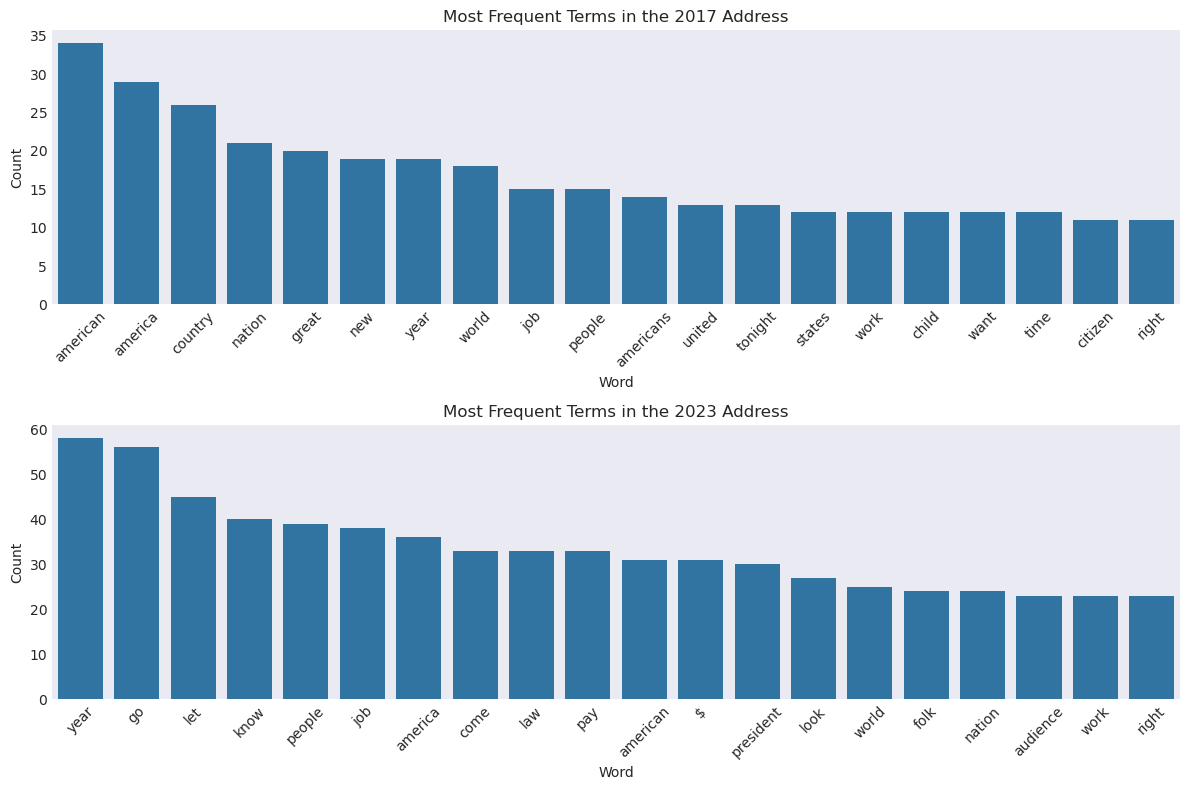

In [47]:
# Draw the bar charts
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Chart for 2017
sns.barplot(data=df_2017, x="Word", y="Count", ax=axes[0])
axes[0].set_title("Most Frequent Terms in the 2017 Address")
axes[0].tick_params(axis="x", rotation=45)

# Chart for 2023
sns.barplot(data=df_2023, x="Word", y="Count", ax=axes[1])
axes[1].set_title("Most Frequent Terms in the 2023 Address")
axes[1].tick_params(axis="x", rotation=45)

plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.savefig("outputs/2.1_State_of_the_Union_Most_Frequent_Words.png", dpi=300, bbox_inches="tight")
plt.show()


### TF-IDF Vectorization

To use statsitical alorithms on documents, we need to transform them into vectors, where each element of the vector corresponds to a particular word in a document or corpus of documents. One common way is via TF-IDF embeddings. LLMs work similarly - they typically use transformer models to generate text embeddings before sending text through a deep neural network. 

Here we will fit a TF-IDF vectorizer, plot all the speeches on a 2-D grid using PCA and also using a heatmap, and examine TF-IDF scores for the top 10 most common words in the first speech. This is a good resource here: https://medium.com/GeoffreyGordonAshbrook/vector-visualization-2d-plot-your-tf-idf-with-pca-83fa9fccb1d 

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

#### Train the Vectorizer and Transform the Data

In [49]:
# you may use this as input to fit the TF-IDF vectorizer
raw_docs = sou["Text"].to_list()

In [50]:
# Hint - use fit_transform for vectorizer and PCA

# Initialize TF-IDF vectorizer (default tokenizer is fine)
tfidf_model = TfidfVectorizer()

# Fit the model and transform the speeches into TF-IDF vectors
tfidf_vectors = tfidf_model.fit_transform(raw_docs).toarray()

print(f"TF-IDF matrix shape: {tfidf_vectors.shape}")


TF-IDF matrix shape: (246, 25957)


The output of `fit_transform()` will be a matrix where each row corresponds to a speech, each column corresponds to a word in the corpus of speeches, and the value is the TF-IDF score which measures the importance of that word in that speech, relative to the rest of the speeches.

#### Plot Speeches

- First used PCA to generate the first chart
- Second use seaborn heatmap with a log-scaled color axis to generate the second chart

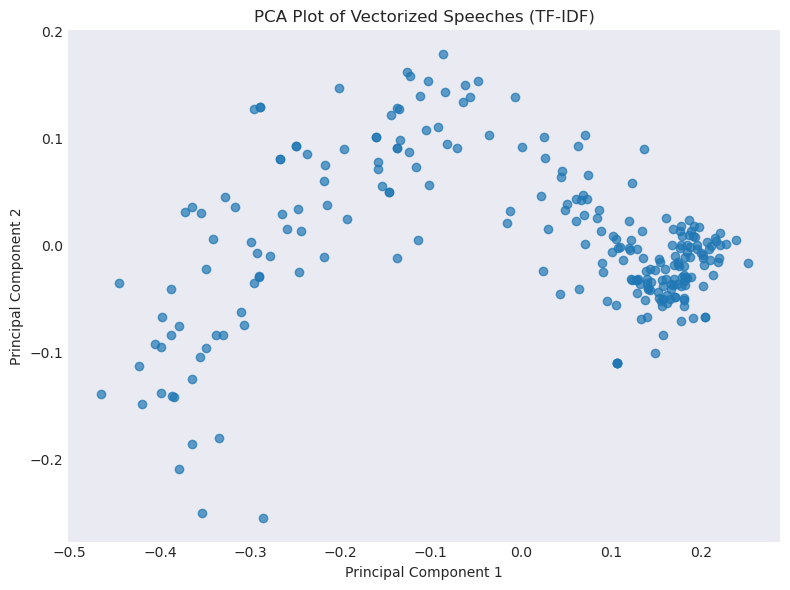

In [51]:
# Step 1: Set PCA to find first 2 principal components
pca = PCA(n_components=2)

# Step 2: Create a new dataframe where each row is a speech, and each column is a projection onto
# one of the two principal components
df2d = pd.DataFrame(pca.fit_transform(tfidf_vectors), columns=["x", "y"])

plt.figure(figsize=(8, 6))
plt.scatter(df2d["x"], df2d["y"], alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Plot of Vectorized Speeches (TF-IDF)")
plt.tight_layout()
plt.savefig("outputs/vectorized_speeches_principal_components.png")
plt.show()

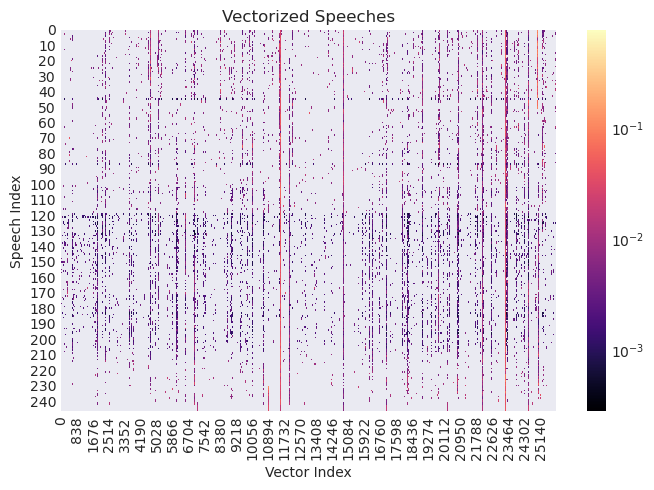

In [52]:
# Hint - vectorized_docs is a sparse matrix whose rows are speeches and columns are tokens, with each
# value being a TF-IDF score. Densify this array first, and then plot using seaborn.
# TF-IDF HEATMAP WITH LOG-SCALED COLOR AXIS
from matplotlib.colors import LogNorm

# Convert sparse matrix → dense matrix
dense_tfidf = tfidf_vectors  # Already dense if you used .toarray() earlier
# If yours is sparse, uncomment:
# dense_tfidf = tfidf_vectors.toarray()

plt.figure(figsize=(7, 5))

sns.heatmap(
    dense_tfidf,
    norm=LogNorm(),
    cmap="magma",
)

plt.title("Vectorized Speeches")
plt.xlabel("Vector Index")
plt.ylabel("Speech Index")

plt.tight_layout()
plt.savefig("outputs/2.3_Vectorized_Speeches.png", dpi=300, bbox_inches="tight")
plt.show()


#### Get the TF-IDF value for certain words and documents

In [53]:
word_list = ['year',
 'america',
 'people',
 'american',
 'work',
 'new',
 'job',
 'country',
 'americans',
 'world'] # top ten most common words through whole corpus

In [54]:
word_nums = tfidf_model.vocabulary_ # get each word's index number using the .vocabular_ attributed of vectorizer

In [55]:
idf_score = []
for word in word_list:
    idx = word_nums[word]
    idf_score.append(tfidf_model.idf_[idx]) # get their IDF score by using .idf_ at the indices from the previous step

In [56]:
tf_idf = []
for word in word_list:
    idx = word_nums[word]
    tf_idf.append(tfidf_vectors[0, idx])


In [57]:
pd.DataFrame({"Word": word_list, "IDF Score": idf_score, "TF-IDF Score": tf_idf})

,Word,IDF Score,TF-IDF Score
0,year,1.032925,0.022719
1,america,1.272946,0.068439
2,people,1.037118,0.043087
3,american,1.102217,0.045792
4,work,1.162281,0.005681
5,new,1.024591,0.016275
6,job,2.043480,0.009988
7,country,1.008130,0.013550
8,americans,1.713598,0.041877
9,world,1.138750,0.026438
